# What makes a particular HDB flat 'premium'? 

#### By: Stephanie Wong Soon Yen (for DS102, Sep 2019)
stephaniewong.sg@gmail.com

In [363]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [364]:
!pip install selenium 

# Executive Summary (includes Problem Statement)

### Background and Research Question
Buying a property is a significant purchase in one's lives, and we assume that when a buyer is willing to pay a higher price for a certain flat, there are features that the buyer values in the flat. Existing data and studies do explore how features like location can affect a flat's pricing. Furthermore, we know that variables like flat size and area will affect the price. 

Beyond this, I wonder what other 'qualitative' features make a flat 'premium' (i.e. more desirable than others of similar size and in the same town). Anecdotally, we know there are many other 'qualitative' factors that buyers will value, such as whether a flat has a nice/unblocked view, or is located on a high floor. These factors may be hard to codify, and not explored. **Hence, I want to find out what are some of these features that buyers look out for through text analysis, and explore how such features affect a flat's pricing.**

There is a **use case** for these machine learning models trained (Naives Bayes classifier, linear regression model and decision tree classifier). First, we can feed new text blurbs in advertisements into the text classifier, to pick out what features a new flat listed for sale has. Then, we can use the models (e.g. decision tree classifier) to predict if a flat will sell for an above-average or below-average price.



**Objectives/Steps**: 

1) Identify features that could affect a flat's price based on text comments/blurbs from property listings.

2) Train and use a multi-label text classifier (NB) to predict the features of a flat from textual comments/blurbs in advertisements. This can be used to predict features of future listings.

3) Quantify the relationship between these features and whether a flat can ask for an above-average price in a model (linear regression and decision tree classifier)



### Summary of Findings

By examining web-scraped property listings of HDB flats on 99.co, some key findings:
1) The **most commonly promoted features** of a flat are: 
<br> a) Proximity to MRT 
<br> b) Whether a flat is renovated
<br> c) Whether a flat has a nice unblocked view
<br> d) Whehter a flat is on a high floor
<br> e) Whether a flat is a corner unit
<br> f) Whether a flat is close to amenities like shops, supermarkets, coffeeshops

There is some correlation between some of these features. Flats that are advertised as being near to the MRT tend to be close to amenities (0.42) and flats that are advertised with unblocked view tend to be on high floors (0.33).

2) When using a linear regression model, the feature that has the greatest effect on psf pricing is **whether a flat is renovated** (largest coefficient). 

3) When using decision tree classifier, the feature that has the greatest effect on psf pricing is **whether a flat is near to the MRT**. 

# Dataset Selected

I want to obtain a dataset that shows what are some features that buyers look out for when buying a flat. Short of conducting a survey with many buyers, I decide to use property listings as a proxy. Assuming that sellers/agents are able to understand what buyers want, the features of the flat highlighted in property listings will show me features that affect a flat's price. 

Since the property listings will indicate the asking price, this will show me how desirable sellers/agents believe that their features of their flat are. To obtain this data, I visit http://99.co, which is a website with property listings. I will obtain the dataset by web-scraping.

I need to scope the data further to omit the effects of variables that we know affect pricing, but which are outside of my analysis (as I want to look at 'qualitative' factors that make a flat 'premium'). 

1) Omit effect of flat size - use per sq ft (psf) pricing instead of total asking price

2) Omit effect of different property types (i.e. HDB vs private) - use only HDB flat sales

3) Omit effect of different HDB towns - compare data only within HDB towns, and scope the study to look at one HDB town (Ang Mo Kio). Ang Mo Kio has a relatively higher proportion of HDB flats compared to private properties, compared to other towns.

# Methodology, Insights and Evaluation

## Gathering Data: Web Scraping

In [6]:
from selenium import webdriver
import time
import re
import nltk

In [15]:
path_to_chromedriver = './chromedriver.exe'

driver = webdriver.Chrome(executable_path = path_to_chromedriver)

#show hdb town amk, for sale, hdb only, 1st page 
url = 'https://www.99.co/singapore/s/sale?listing_type=sale&main_category=hdb&map_bounds=1.5827095153768858%2C103.49449749970108%2C1.1090706240313446%2C104.12483807587296&need_change_bounds=true&page_num=1&page_size=25&property_segments=residential&query_coords=1.3039947%2C103.8298507&query_ids=htang_mo_kio&query_limit=radius&query_type=hdb_town&radius_max=1000&rental_type=unit&show_cluster_preview=true&show_future_mrts=true&sub_categories=hdb_2r%2Chdb_3r%2Chdb_4r%2Chdb_5r%2Chdb_executive&zoom=13'
driver.get(url)
    

First, I navigate to the page which has already filtered for my desired town, Ang Mo Kio. There are 25 full pages of listings. Each page has 25 listings. For each listing, there is a psf. Hence, I will use Selenium to web-scrape it and store it into a list. Since the webdriver will search and store the HTML according to the order it appears on the page, the order of the list will correspond to the order of the listing. 

It is important to maintain the order, so that when I scrape the text comment for the listings later, each psf will correspond to its text comment for the same listing due to indexing. 

In the cells below, use a simple for-loop and the webdriver to obtain the HTML with the PSF value. 

Examining the HTML of the webpage showed that I have to get the webdriver to search by tag p because the other xpath for the desire PSF element changes on different pages. 

In [10]:
bt_amk_sale_tag_p=[]

try:
    for i in range(25):

        comments_element = driver.find_elements_by_tag_name("p")
            
        for elem in comments_element:
            comment_html = elem.get_attribute('innerHTML')
            comment_soup = BeautifulSoup(comment_html)
            comment_text = comment_soup.text

            bt_amk_sale_tag_p.append(comment_text)

        driver.find_element_by_class_name("next").click() #next page

        time.sleep(3)
#         print('one page') #check progress
except:
    print('error')


In [11]:
bt_amk_sale_tag_p[:10] #check output

['Avenue South Residence',
 'A modern luxury condominium with dual 56-storey towers devel...',
 'Meyer Mansion',
 'Located in the residential district of East Coast, Meyer Man...',
 'D20\nHDB 4 Rooms\n1980 (39 yrs)',
 'For sale:',
 '$368,000',
 '3 Bed 2 Bath',
 '$375.51 psf ',
 '980 sqft / 91 sqm']

However, when I scrape by the p tag, it also gives me other elements in the listing with this tag. Thus, I must filter out to obtain only the psf element.

In [12]:
#filter out for only psf values and append to new list
bt_amk_sale_psf = []

for entry in bt_amk_sale_tag_p:
    if ('psf' in entry):
        bt_amk_sale_psf.append(entry)
    else:
        pass 


In [13]:
#check output
print(len(bt_amk_sale_psf)) #25 pages, 625 entries
bt_amk_sale_psf[:5]

625


['$375.51 psf ',
 '$442.38 psf ',
 '$376.38 psf ',
 '$396.17 psf ',
 '$471.65 psf ']

In [ ]:
path_to_chromedriver = './chromedriver.exe'

driver = webdriver.Chrome(executable_path = path_to_chromedriver)

#show hdb town amk, for sale, hdb only, 1st page 
url = 'https://www.99.co/singapore/s/sale?listing_type=sale&main_category=hdb&map_bounds=1.5827095153768858%2C103.49449749970108%2C1.1090706240313446%2C104.12483807587296&need_change_bounds=true&page_num=1&page_size=25&property_segments=residential&query_coords=1.3039947%2C103.8298507&query_ids=htang_mo_kio&query_limit=radius&query_type=hdb_town&radius_max=1000&rental_type=unit&show_cluster_preview=true&show_future_mrts=true&sub_categories=hdb_2r%2Chdb_3r%2Chdb_4r%2Chdb_5r%2Chdb_executive&zoom=13'
driver.get(url)

Next, I need to scrape the text comments. Some listings have a text comment / blurb written by the seller/agent to promote some features of the flats. 

As explained earlier, indexing is important. However, there is an issue because some listings do not have this text comment element at all. If I use a simple for-loop with the webdriver find_elements_by, it will only find (and hence run code) for some listings, so I cannot append a dummy value for listings with no desired element, as the webdriver will not be able to find it and run my code. Then, my indexing will not tally with the psf one above. 

Thus, I need to first find a parent element which every listing has. Then, I search within the parent element for the desired HTML element of text comment using a for loop. If it is not found, I can then append a dummy value.


In [16]:
bt_amk_sale_comments=[]

#first loop - to go through each page
for pgnum in range(25):
    #in each page, obtain list of parent element
    parent_element = driver.find_elements_by_class_name('SearchListingItem__infoWrapper__21qU9') #list of webdriver objects
    
    for i in range(len(parent_element)): #loop for the same number of times as listings
    
        try:
            comments_element = parent_element[i].find_element_by_class_name('Highlights__highlight__2awfJ')
            comment_html = comments_element.get_attribute('innerHTML')
            comment_soup = BeautifulSoup(comment_html)
            comment_text = comment_soup.text
            
            bt_amk_sale_comments.append(comment_text)
    
        except:
            bt_amk_sale_comments.append('blankvalue')
        
    time.sleep(3)
#     print('one page') #check progress
        
    driver.find_element_by_class_name("next").click() #next page

In [17]:
#check output
print(len(bt_amk_sale_comments)) #25 pages, then 625 entries, same as psf, checked index tallies
bt_amk_sale_comments

625


['4A only 7 years old apt.\nNear AMK HUB, Shopping Mall\nNear AMK MRT Station\nNear AMK Bus Interchange\n',
 'HDB FOR SALE - 4NG NEAR AMK MRT / MALL',
 '➡ 4 Bedrooms \n➡ Unblock View \n',
 '[PRICED TO SELL] Ethnic Quota Filled For Chinese (March 2019)',
 'blankvalue',
 '520 Ang Mo Kio Avenue 5',
 '5 room flat at 501 Ang Mo Kio Avenue 5',
 'Corner Spacious Well Maintained 4NG',
 'Mid Floor Corner Unit',
 'High floor \nRare \nFor investment \n',
 'blankvalue',
 'blankvalue',
 'Mop Soon! Brand New, Renovated, Quiet Facing, Near MRT! Must Enquire!',
 'Near Yio Chu Kang Mrt \nToilet HIP just done',
 'Corner Unit, Mid Floor, Renovated',
 'blankvalue',
 'Excellent location like Centro Residences but selling at 37% of Centro prices. 3 mins to AMK MRT. ',
 'blankvalue',
 'Beautifully renovated 334 Ang Mo Kio Ave 1 - 4bdrm - Choice unit ',
 'Call 90086649\n\n2RM blk 510 Ang Mo Kio',
 'Asking $318K Nego',
 'blankvalue',
 'blankvalue',
 'CALL NOW: 9004-8442! THANK YOU',
 'Two units per floor. Door

In [21]:
#gathering data into 1 dataframe

#convert psf to to df
full_amk_df = pd.DataFrame(bt_amk_sale_psf)

#creating one df to hold both series
full_amk_df['comment'] = bt_amk_sale_comments
full_amk_df.columns = ['psf', 'comment']

#check
print(len(full_amk_df))
full_amk_df.head()

625


,psf,comment
0,$375.51 psf,"4A only 7 years old apt.\nNear AMK HUB, Shoppi..."
1,$442.38 psf,HDB FOR SALE - 4NG NEAR AMK MRT / MALL
2,$376.38 psf,➡ 4 Bedrooms \n➡ Unblock View \n
3,$396.17 psf,[PRICED TO SELL] Ethnic Quota Filled For Chine...
4,$471.65 psf,blankvalue


In [ ]:
#save scraped data to csv and save data to use to csv

## Cleaning Data

As the website will change its listings and possibly some of the class names (or other elements that were used), I will save the data scraped into a .csv file and import it back to use for analysis.

In [365]:
#to ensure data stays the same, as listings may change, import the data back
full_amk_df = pd.read_csv('full_amk_retrieved_scrape_to_import.csv')
full_amk_df.drop(['Unnamed: 0'], axis=1)

,psf,comment
0,290,blankvalue
1,399.39,5 room flat at 501 Ang Mo Kio Avenue 5
2,527.98,"4A only 7 years old apt.\r\nNear AMK HUB, Shop..."
3,408.47,blankvalue
4,480.08,Sale -Renovated 4NG in 209 Ang Mo Kio Ave 3
5,480.08,Spacious Interior and Simple Renovation unit t...
6,388.63,For Sale - Blk 134 4NG for Sale\r\nMRT - Ang M...
7,360.53,Rare 4 Room Upgraded with Utility Room
8,348.36,538 Ang Mo Kio Avenue 5
9,530.41,"Blk 351, Simple, Bright and windy, Chinese Not..."


#### Cleaning Data (psf) and Dropping Rows with No Comments
Rows with no comments must be dropped, as we cannot analyse any features. Out of the 625 listings (rows) originally, 183 were dropped.

In [366]:
import re

#clean by removing unnecessary symbols and change values in psf to numeric value 
# define function to apply to df to clean psf
def extract_psf_num(entry):
    entry = re.sub("[a-z$,]","", entry)
    
    return entry

#apply function
full_amk_df['psf'] = full_amk_df['psf'].apply(extract_psf_num)

In [367]:
#replace str 'blankvalue' for comment with null value (naN)
full_amk_df = full_amk_df.replace('blankvalue', np.nan)
full_amk_df[:10] #check

#drop all rows in df with empty comment, as it cannot be used for analysis and cannot be filled in logically
amk_df = full_amk_df.dropna(axis=0)

#check output
#amk_df.head() 
#len(amk_df)

In [368]:
#convert psf to numeric
amk_df['psf'] = amk_df['psf'].astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [369]:
#check
amk_df

,Unnamed: 0,psf,comment
1,1,399.39,5 room flat at 501 Ang Mo Kio Avenue 5
2,2,527.98,"4A only 7 years old apt.\r\nNear AMK HUB, Shop..."
4,4,480.08,Sale -Renovated 4NG in 209 Ang Mo Kio Ave 3
5,5,480.08,Spacious Interior and Simple Renovation unit t...
6,6,388.63,For Sale - Blk 134 4NG for Sale\r\nMRT - Ang M...
7,7,360.53,Rare 4 Room Upgraded with Utility Room
8,8,348.36,538 Ang Mo Kio Avenue 5
9,9,530.41,"Blk 351, Simple, Bright and windy, Chinese Not..."
10,10,385.49,High floor lift level spacious
11,11,448.82,High floor no west sun unblock view


## Exploratory Data Analysis

### EDA for Per Sq Ft (PSF) Pricing Data ($)

In [370]:
print(amk_df['psf'].describe())

count     456.000000
mean      478.705833
std       463.777109
min       305.780000
25%       384.310000
50%       412.120000
75%       453.397500
max      7094.020000
Name: psf, dtype: float64


First, I visualise the distribution of PSF data below.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of Per Sq Ft Pricing (PSF) ($) BEFORE Filtering Out Outliers')

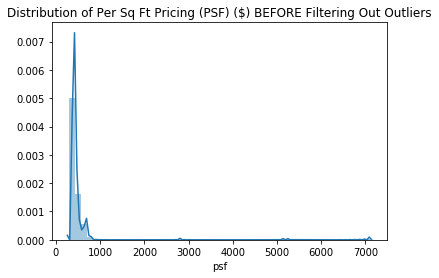

In [371]:
sns.distplot(amk_df['psf'])
plt.title('Distribution of Per Sq Ft Pricing (PSF) ($) BEFORE Filtering Out Outliers')
# plt.savefig('dsitributionpsfbefore.png')

From the distribution above, I can see there are outliers that need to be filtered out. 

#### Outlier Detection

In [372]:
#examine distribution of data in quartiles, calculate IQR
q3 = amk_df['psf'].quantile(q=0.75)

IQR = q3-q1
lowerbound = q1 - 1.5*IQR
upperbound = q3 + 1.5*IQR
print('lower bound is:', lowerbound, 'upper bound is:', upperbound)

lower bound is: 259.1817178041471 upper bound is: 569.9269693175117


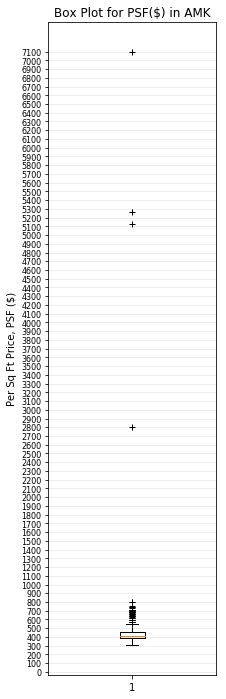

In [373]:
#visualise distribution in boxplot

fig = plt.figure(figsize=(3, 12))
ax1 = plt.subplot(111)
ax1.boxplot(amk_df['psf'], sym='+', whis=1.5)
ax1.set_ylabel('Per Sq Ft Price, PSF ($)')
ax1.set_title('Box Plot for PSF($) in AMK')
ax1.set_yticks(np.arange(0, 7200, 100))
ax1.set_yticklabels(labels=np.arange(0, 7200, 100), fontsize=8)
ax1.yaxis.grid(True, linestyle='-', color='lightgrey', alpha=0.5)
plt.show()
# plt.savefig('boxplotbefore.png')

In [374]:
#outlier detection
outliers_amk_psf_df = amk_df[~amk_df['psf'].between(lowerbound, upperbound)]
print(len(outliers_amk_psf_df))

#filter out outliers
indexes_to_drop_outlier = []
for index in amk_df.index:
    psf = amk_df['psf'][index]
    if (psf<lowerbound) or (psf>upperbound):
        indexes_to_drop_outlier.append(index)
    else:
        pass

# print(len(indexes_to_drop_outlier)) #check

46


In [375]:
#drop all outliers and create new df
amk_filter_df = amk_df.drop(indexes_to_drop_outlier)
len(amk_filter_df) #check

410

After filtering out the 49 outliers, we have 407 listings (rows) left. Then, I check by visualising the distribution after filtering out outliers below.

Text(0.5, 1.0, 'Distribution of Per Sq Ft Pricing (PSF) ($) AFTER Filtering Out Outliers')

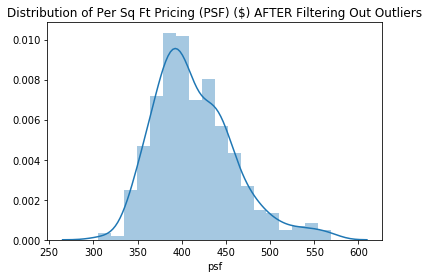

In [376]:
sns.distplot(amk_filter_df['psf'])
plt.title('Distribution of Per Sq Ft Pricing (PSF) ($) AFTER Filtering Out Outliers')
# plt.savefig('dsitributionpsfafter.png')

### EDA for Comment (Textual) Data 

#### Text Normalisation: Simple Cleaning

In [377]:
#cleaning
def clean_description(text):
    text = text.lower() #Lowercase
    text = text.strip() #remove empty spaces
    text = re.sub("[^0-9a-zA-Z\ ]", "", text) #alphanumeric characters only
        
    return text

amk_filter_df['comment'] = amk_filter_df['comment'].apply(clean_description)


In [378]:
#remove words that are redundant in this case, like ang mo kio 
def clean_redundant(text):
    text = re.sub("ang mo kio", "", text) #alphanumeric characters only
        
    return text

amk_filter_df['comment'] = amk_filter_df['comment'].apply(clean_redundant)

#### Text Normalisation: Tokenisation,  Lemming and Stop Word Removal


In [379]:
#tokenise 
from nltk.tokenize import word_tokenize

comments_list = amk_filter_df['comment'].tolist()
tokenized = []

for entry in comments_list:
    tokens = word_tokenize(entry)
    tokenized.append(tokens)
    
# tokenized #list of lists #check

#remove stopwords
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

def clean_stopwords(desc):
    tokens = word_tokenize(desc)
    no_stopwords = []
    for token in tokens:
        if token not in STOP_WORDS:
            no_stopwords.append(token)
    string = ""
    for word in no_stopwords:
        string += " "+word
    return string

amk_filter_df['comment'] = amk_filter_df['comment'].apply(clean_stopwords)

In [380]:
#pos tagging
#change words in list of lists tokenized, extract each word and append to list of words for pos
all_tokens_in_one_list = []
for entry in tokenized:
    for word in entry:
        all_tokens_in_one_list.append(word)
    # all_tokens_in_one_list #check

tagged_all_tokens_in_one_list = nltk.pos_tag(all_tokens_in_one_list)
# tagged_all_tokens_in_one_list #check

In [381]:
#lemmatisation
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize(pair):
    word, tag = pair
    try:
        return lemmatizer.lemmatize(word, pos=tag[0].lower())
    except KeyError:
        return word
    
lemmatized = []

for word in tagged_all_tokens_in_one_list:
    lemmatized.append(lemmatize(word))

# len(lemmatized)
# lemmatized

In [382]:
#to prevent word cloud from displaying ' as part of the word, convert the list of strings into a list with only 1 string
lemmatized_one_string = ""
lemmatized_one_string = " ".join(lemmatized)
# lemmatized_one_string

After text normalisation, I visualise the words in the comments using a word cloud.

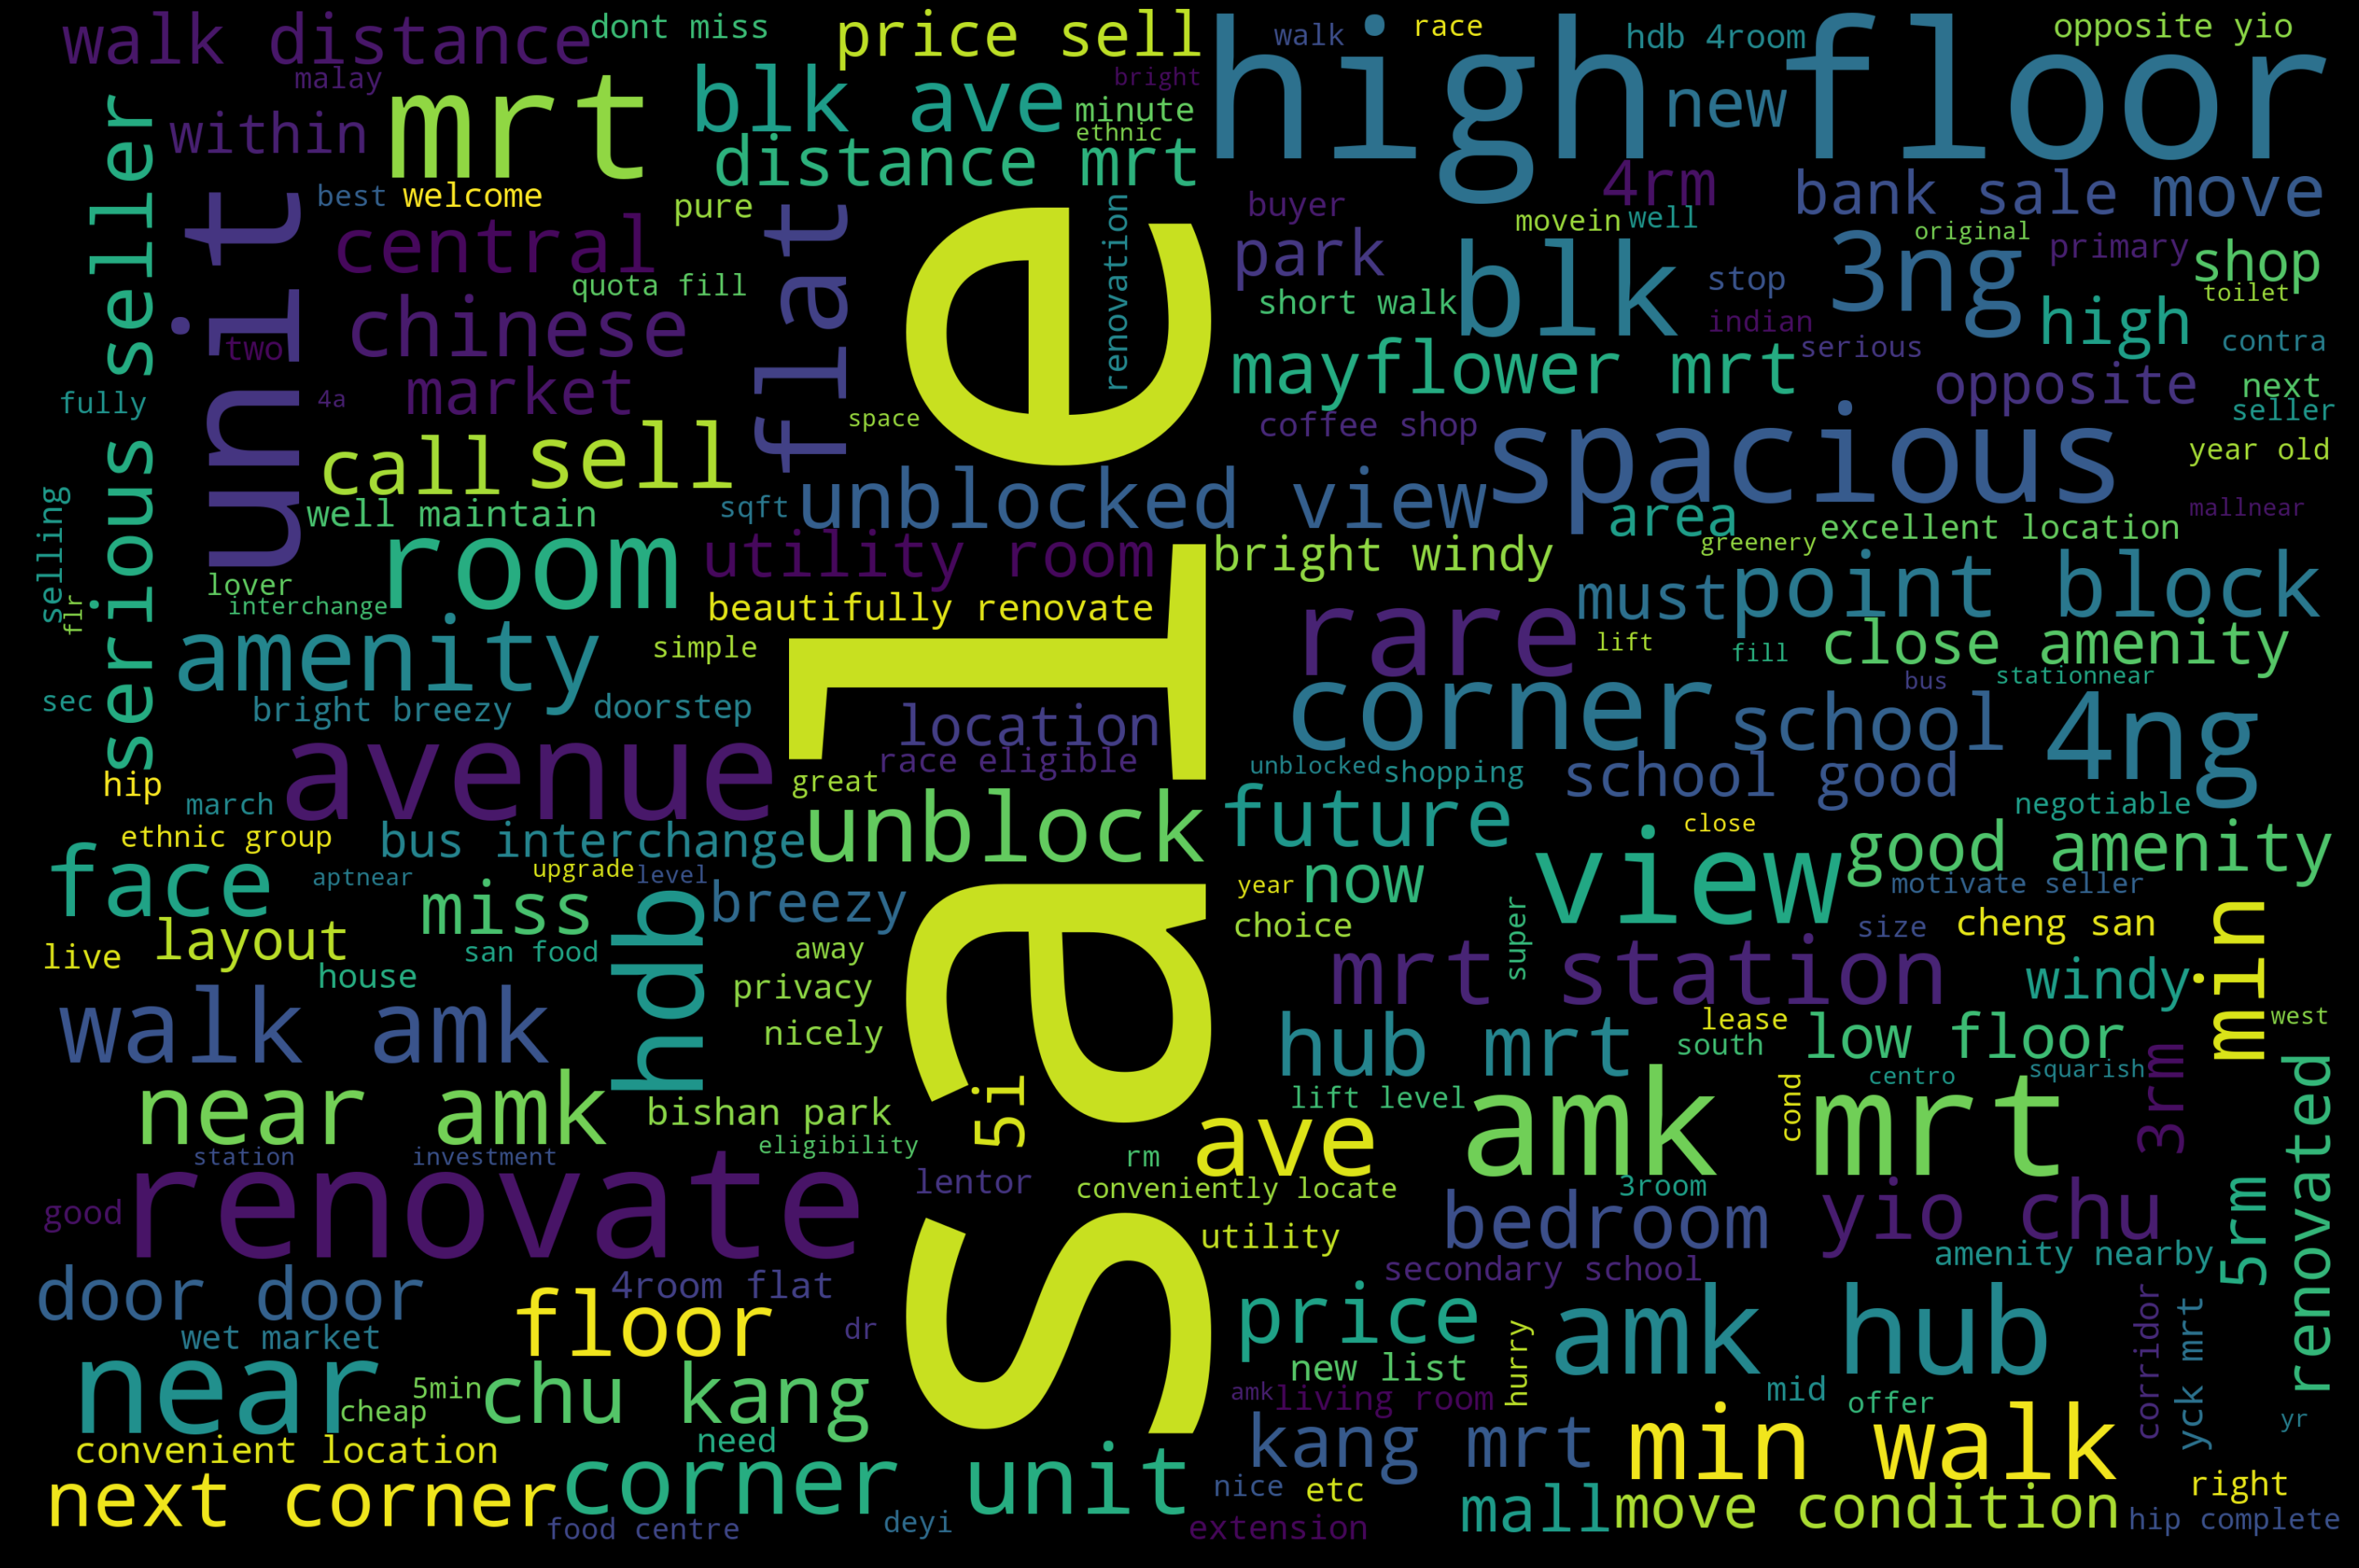

<Figure size 432x288 with 0 Axes>

In [383]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = lemmatized_one_string
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.savefig('wordcloud.png')

From the word cloud above, I get an idea of what are some of the more popular words. However, it would be clearer to visualise the popular words in a bar graph below.

In [384]:
#visualise count of popular words in bar graph to see popular words
unique_word_count_dict = {}

for word in lemmatized:
    if word not in unique_word_count_dict:
        unique_word_count_dict[word] = 1
    else:
        unique_word_count_dict[word] += 1

#unique_word_count_dict #check

popular_unique_word_count_dict = {}

for key, value in unique_word_count_dict.items():  
    if value>25:
        popular_unique_word_count_dict[key] = value
    else:
        pass
        
popular_unique_word_count_dict

{'5': 28,
 'room': 35,
 'flat': 27,
 'avenue': 30,
 'amk': 88,
 'hub': 27,
 'mrt': 120,
 'sale': 69,
 'renovate': 43,
 'ave': 29,
 '3': 27,
 'spacious': 28,
 'and': 39,
 'unit': 58,
 'to': 124,
 'for': 78,
 'blk': 37,
 'high': 63,
 'floor': 75,
 'view': 36,
 'near': 42,
 'hdb': 26,
 'corner': 46,
 'amenity': 33,
 'min': 27,
 'walk': 46}

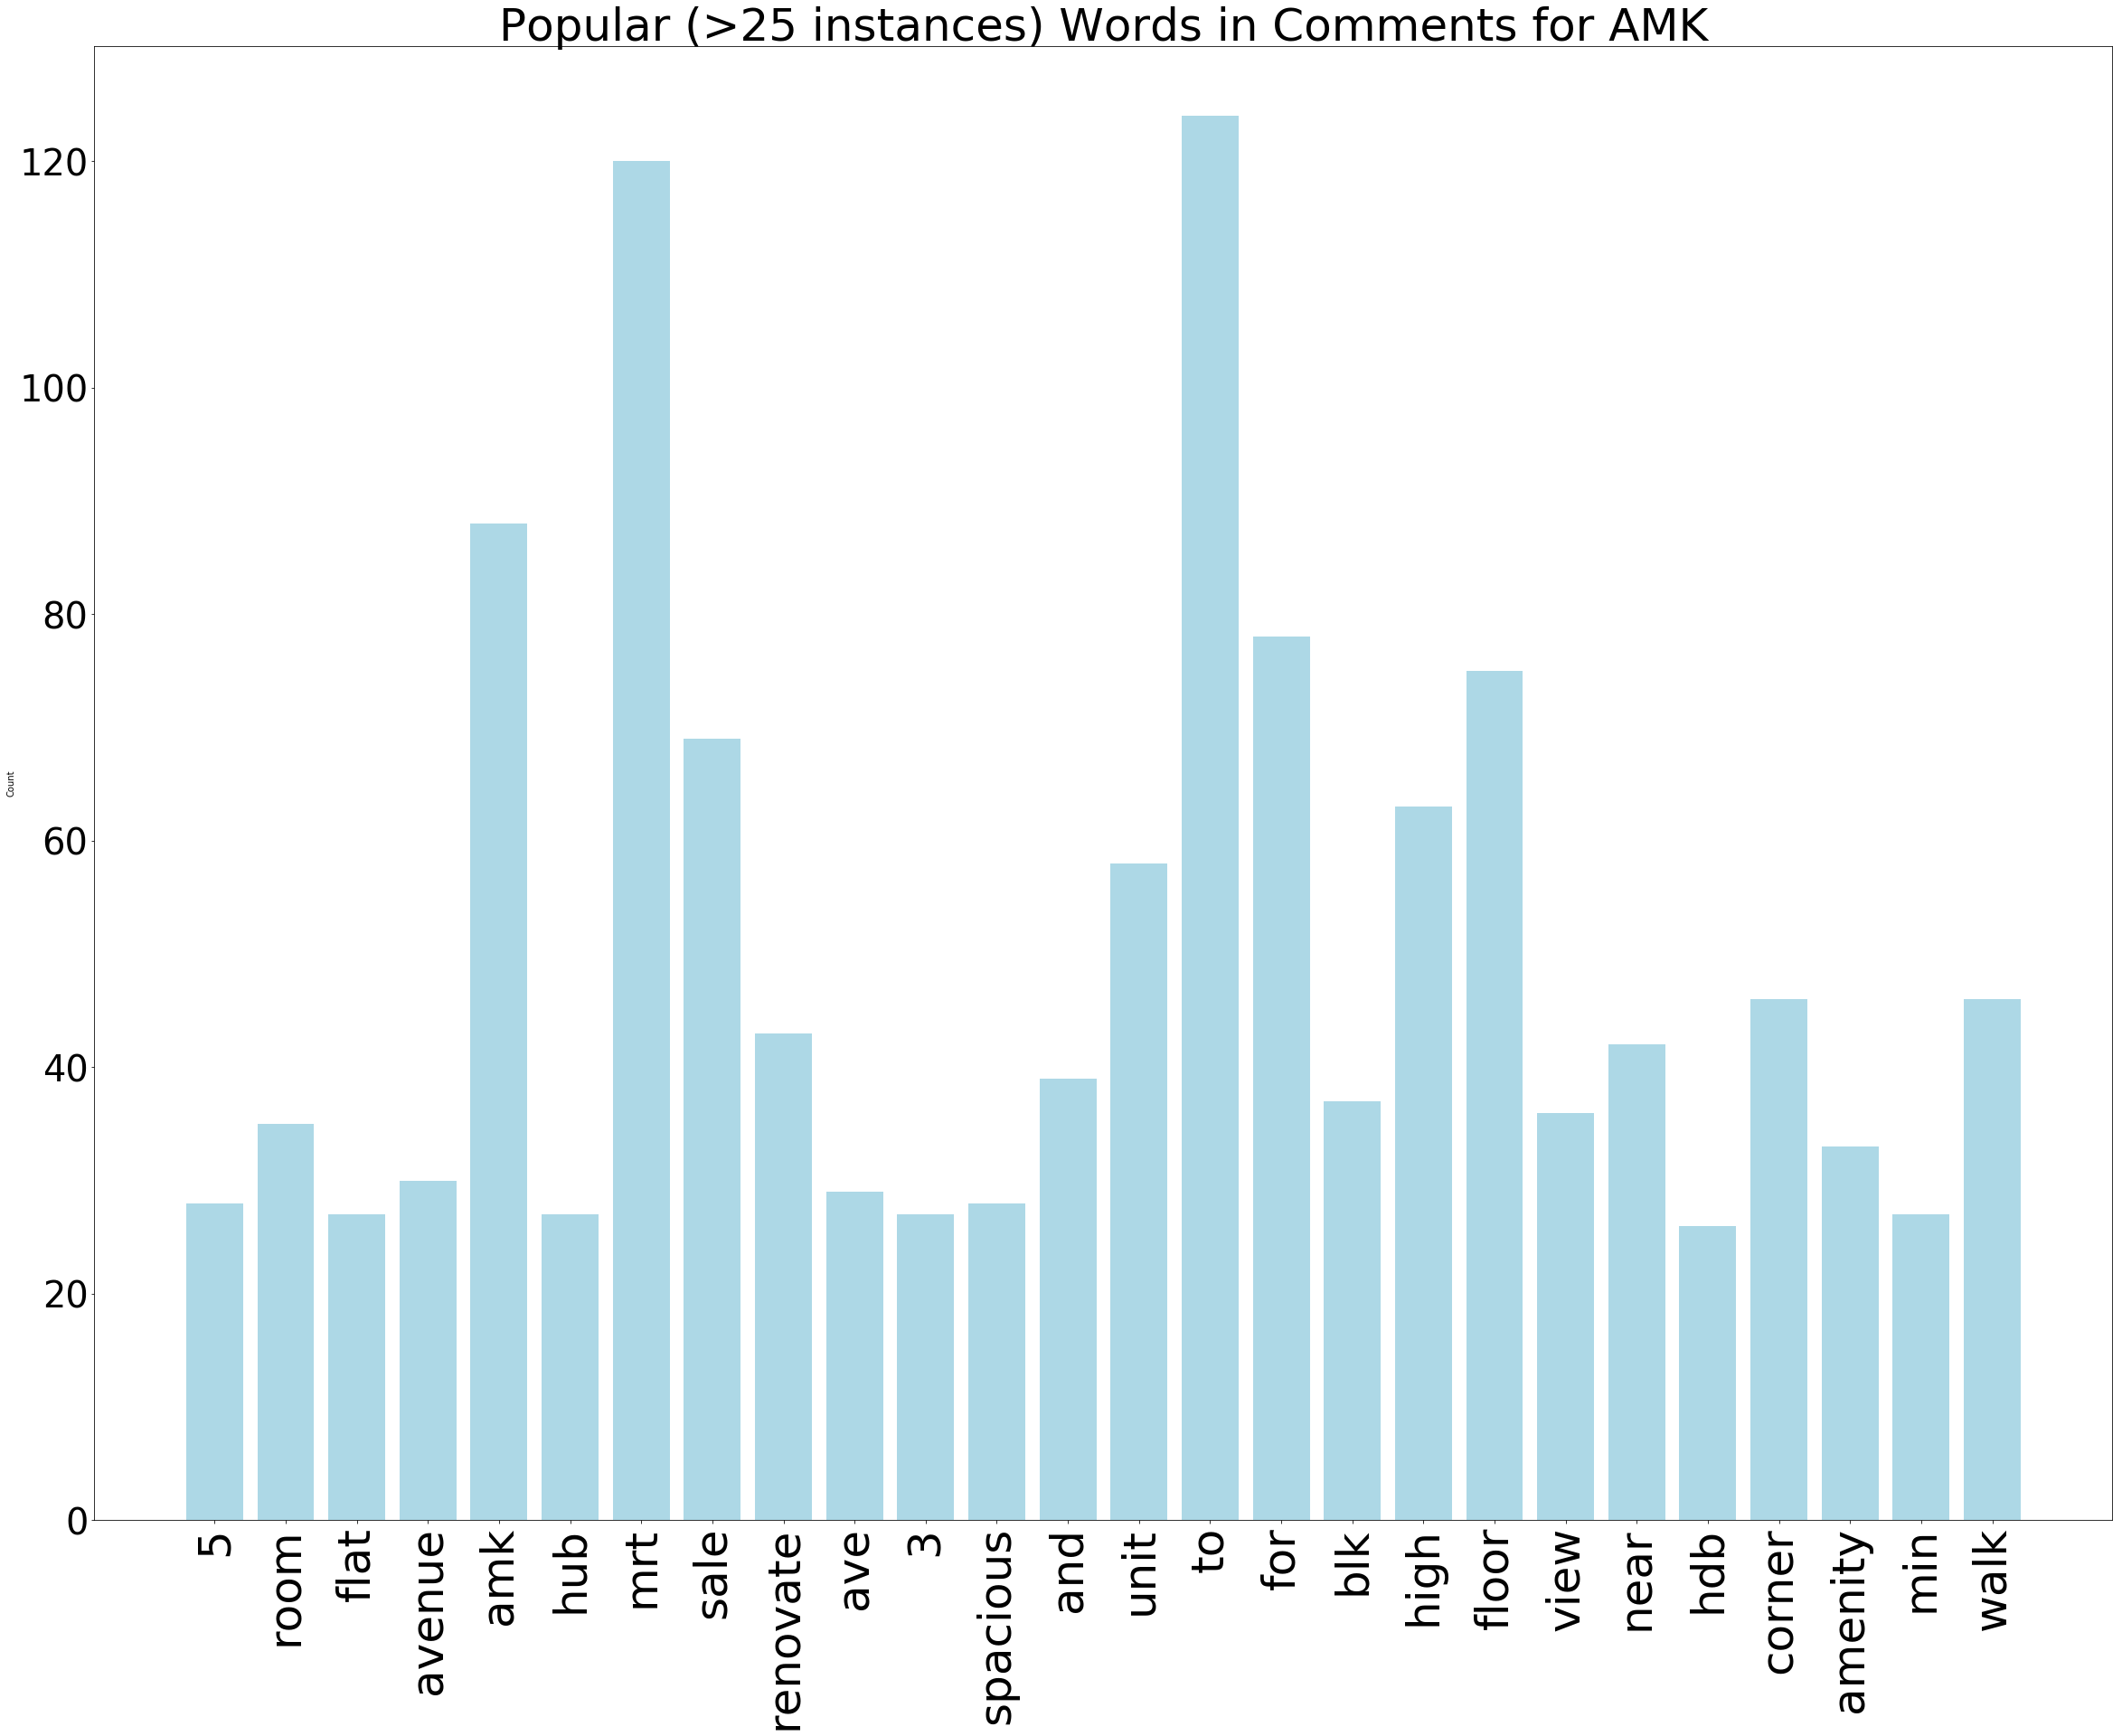

In [385]:
X_wordcount = list(popular_unique_word_count_dict.keys())
Y_wordcount = list(popular_unique_word_count_dict.values())

fig = plt.figure(figsize = (40, 30))
plt.bar(X_wordcount, Y_wordcount, color='lightblue')
plt.title('Popular (>25 instances) Words in Comments for AMK', fontsize=50)
plt.ylabel('Count')
plt.yticks(fontsize=40)
plt.xticks(rotation=90, fontsize=50)
plt.show()
# plt.savefig('bar_popularwords.png')

From the bar graph above, I can see some of the common words in the text comments. Some words like 'room', 'sale' or 'flat' are useless as they would appear often in any comment, but are not features that the seller wants to promote. 

From the bar graph, I pick out some features/categories below that are commonly promoted and then use this to prepare my data to use to train my machine learning models.

In [428]:
labels_for_comments = ['mrt', 'renovate', 'view', 'high', 'corner', 'amenities']
labels_for_comments_dict = {0: 'mrt',
                           1: 'renovate',
                           2: 'view', #includes the word unblocked which is also quite popular
                           3: 'high', #high floor
                           4: 'corner',
                           5: 'amenities'} #shops, market, amk hub}

## Machine Learning Models - Multi-label text Naives Bayes classifier, Linear Regression, Decision Tree Classifier

First, I export the dataframe to csv to use Excel to label the comments. I am using multi-label text classification. Each comment can promote more than one feature, hence multi-label text classification is needed.

After I label the text, I import the file back into a new dataframe.

In [429]:
#filter out filtered data to csv for labelling
amk_filter_df.to_csv('amk_filtered_for_labelling.csv')

In [430]:
#import into labelled data
amk_labelled_old__df = pd.read_csv("amk_filtered_labelled.csv")

In [431]:
amk_labelled_df = amk_labelled_old__df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [432]:
amk_labelled_df.head()

,psf,comment,mrt,renovate,view,high,corner,amenities
0,399.39,5 room flat 501 avenue 5,0,0,0,0,0,0
1,527.98,4a 7 years old aptnear amk hub shopping malln...,1,0,0,0,0,1
2,480.08,sale renovated 4ng 209 ave 3,0,1,0,0,0,0
3,480.08,spacious interior simple renovation unit move,0,1,0,0,0,0
4,388.63,sale blk 134 4ng salemrt viewing appt 90256625,1,0,0,0,0,0


### Machine Learning Algorithm - Multi-label text Naives Bayes Classifier
Purpose: After training the model, we can feed in new text and predict what categories the text will fit into. Hence, we will be able to feed new 'comments' written by sellers about their flat in advertisements, and predict what features (e.g. whether it is renovated etc) it has.

###### Train-test split

In [433]:
#train test split for text algorithm
print(len(amk_labelled_df))
amk_train_text_df = amk_labelled_df[:366]
amk_test_text_df = amk_labelled_df[366:]


407


###### Fit model

In [434]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer()

matrix = vectorizer.fit_transform(amk_train_text_df['comment'])
matrix.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [435]:
from sklearn.multiclass import OneVsRestClassifier

classifier_text = OneVsRestClassifier(MultinomialNB())
classifier_text.fit(matrix, amk_train_text_df[['mrt', 'renovate', 'view', 'high', 'corner', 'amenities']])

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=None)

###### Use model to predict for testing dataframe

In [436]:
category = amk_test_text_df['comment']
matrix_test = vectorizer.transform(category)
predicted_test = classifier_text.predict(matrix_test)

###### Use samples to see how the model works

In [437]:
t_sample = amk_test_text_df.sample()
s=t_sample.iloc[0]['comment']
print(s)
print(clf.predict(vectorizer.transform([s])))

 right house right price right environment unit miss
[[1 0 0 0 1 0]]


###### Check accuracy

In [438]:
#check accuracy
from sklearn.metrics import accuracy_score
accuracy_score(amk_test_text_df[['mrt', 'renovate', 'view', 'high', 'corner', 'amenities']], predicted_test)

#Suggests that model is about 51% accurate. 

0.5121951219512195

### Machine Learning  - Linear Regression
Purpose: We can train the model, and see how far different features predict the psf price. We can use it to predict if new listings will have a 'premium' on their psf price in the future, based on its features. 

Independent variables (features) are encoded as binary variables (0 or 1). Dependent variable (psf) is continuous. Hence, linear regression is suitable. Other models like logistic regression are not suitable given that the dependent variable is continuous. Assume that the dependent variable can follow a normal distribution and is suitable for linear regression. 

###### Train-test split

In [439]:
from sklearn.model_selection import train_test_split
amk_x_df = amk_labelled_df[['mrt', 'renovate', 'view', 'high', 'corner', 'amenities']]
amk_y_df = amk_labelled_df[['psf']]

#train test split
x_train, x_test, y_train, y_test = train_test_split(amk_x_df, amk_y_df, test_size = 0.15, random_state=0)


###### Correlation matrix
This is to see any relationships between the 6 independent variables.

In [440]:
#corelation matrix to see relationships between independent variables
#feature selection if needed
amk_labelled_xcorr = amk_x_df.corr()
amk_labelled_xcorr = amk_labelled_xcorr.style.background_gradient(cmap='coolwarm')
amk_labelled_xcorr

#suggests some relationship (0.42 amd 0.33) between mrt and amenities, view and high floor
#however, not multicollinearity hence no need to drop

,mrt,renovate,view,high,corner,amenities
mrt,1,-0.0919511,-0.0161053,-0.044699,-0.125007,0.425692
renovate,-0.0919511,1,-0.00512173,0.0935725,0.0138906,-0.108586
view,-0.0161053,-0.00512173,1,0.33351,-0.0460513,-0.0504736
high,-0.044699,0.0935725,0.33351,1,0.213519,-0.0312238
corner,-0.125007,0.0138906,-0.0460513,0.213519,1,-0.0395222
amenities,0.425692,-0.108586,-0.0504736,-0.0312238,-0.0395222,1


###### Fit model

In [441]:
from sklearn import datasets, linear_model

linreg_model = linear_model.LinearRegression()
linreg_model.fit(x_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

###### Obtain coefficients, intercept, linear equation

In [442]:
#interpret and create linear equation
print(linreg_model.coef_)
print(linreg_model.intercept_)

#obtain linear equation
print('PSF = 410.98 + 1.21(mrt) + 16.25(renovate) + 14.84(view) + 6.17(high) -15.81(corner) + 0.056(amenities)')


[[  1.21436576  16.25131294  14.8402154    6.17633038 -15.81189139
    0.05599289]]
[410.98402413]
PSF = 410.98 + 1.21(mrt) + 16.25(renovate) + 14.84(view) + 6.17(high) -15.81(corner) + 0.056(amenities)


###### Assess model performance using r2

In [443]:
from sklearn.metrics import r2_score 
linreg_fitted_values = linreg_model.predict(x_train)

print(r2_score(y_train, linreg_fitted_values))

0.043630999144231075


As seen from the r2 score , it is small at 0.04. This suggests the model's predictive value is low. Thus I will try to do feature selection and a new linear regression model to see if it helps.

###### Feature Selection
I will do feature selection referring to the correlation matrix earlier. I choose to drop 'amenities' as it is closely correlated to 'mrt' and it does not have a strong coefficient.

In [444]:
amk_x_dropped_df = amk_x_df[['mrt', 'renovate', 'view', 'high', 'corner']]

###### Train-test split again

In [445]:
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(amk_x_dropped_df, amk_y_df, test_size = 0.15, random_state=0)


###### Fit model again

In [446]:
linreg_new_model = linear_model.LinearRegression()
linreg_new_model.fit(x_train_new, y_train_new)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

###### Obtain coefficients, intercept, linear equation

In [447]:
print(linreg_new_model.coef_)
print(linreg_new_model.intercept_)

[[  1.23431479  16.24767341  14.83599734   6.17838282 -15.81183396]]
[410.98898677]


###### Assess model performance using r2

In [448]:
linreg_fitted_values_new = linreg_new_model.predict(x_train_new)

print(r2_score(y_train_new, linreg_fitted_values_new))

0.04363078593166492


However, there is not much change in r2 score. Thus, this is not useful. 

Instead of predicting the psf pricing, I try to predict whether the features are going to give the flat a higher than average (premium) psf price or a lower than average one. I feel this may be more helpful - given that there are so many factors that can affect flat's pricing, and my model only accounts for 6 of them, it is not sufficient. Hence, I try to convert the psf price into categorical (above or below average). 

Since the dependent variable is now categorical, I can also use **decision tree classifier.**

### Machine Learning - Decision Tree Classifier

In [449]:
amk_y_df['psf'].describe()

count    407.000000
mean     412.830885
std       43.700768
min      305.780000
25%      382.935000
50%      405.080000
75%      439.070000
max      553.540000
Name: psf, dtype: float64

###### Create new columns which have converted the psf to categorical

In [450]:
#create two new columns, psf_half to categorise if psf is above or below mean
#another column is psf_quart to divide the psf value into their quartiles

amk_psf_mean = amk_y_df['psf'].mean()
amk_psf_half = []
for row in amk_y_df['psf']:
    if row <= amk_psf_mean:
        amk_psf_half.append(0)
    
    else:
        amk_psf_half.append(1)
amk_y_df['psf_half'] = amk_psf_half

q1 = amk_y_df['psf'].quantile(q=0.25)
q2 = amk_y_df['psf'].quantile(q=0.5)
q3 = amk_y_df['psf'].quantile(q=0.75)
q4 = amk_y_df['psf'].quantile(q=1)

# print(q1, q2, q3, q4) # check

amk_psf_quart = []

for row in amk_y_df['psf']:
    if row <= q1:
        amk_psf_quart.append(1)
    elif row <= q2:
        amk_psf_quart.append(2)
    elif row <= q3:
        amk_psf_quart.append(3)
    else:
        amk_psf_quart.append(4)
        
amk_y_df['psf_quart'] = amk_psf_quart


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [451]:
amk_y_df.head() #check

,psf,psf_half,psf_quart
0,399.39,0,2
1,527.98,1,4
2,480.08,1,4
3,480.08,1,4
4,388.63,0,2


###### Train-test split

In [452]:
#choose to divide the psf value into upper and lower half
amk_y_df_dt = amk_y_df[['psf_half']]

#train test split again
x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(amk_x_df, amk_y_df_dt, test_size = 0.15, random_state=0)


###### Fit model

In [453]:
#with the y values in categorical form, can perform decision tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4).fit(x_train_dt, y_train_dt)
dt_model

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

###### Predict

In [454]:
dt_results = dt_model.predict(x_test_dt)
# print(dt_results)

###### Assess model and use confusion matrix to show

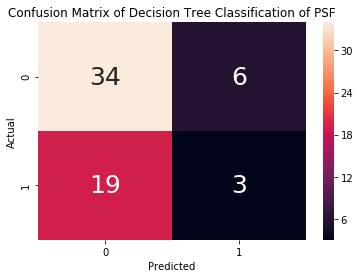

In [455]:
#create confusion matrix
from sklearn.metrics import confusion_matrix

dt_cm = confusion_matrix(y_test_dt, dt_results)

fig = sns.heatmap(dt_cm,
           annot=True,
            fmt ="d",
           annot_kws = {'size':25})
fig.set_title('Confusion Matrix of Decision Tree Classification of PSF')
fig.set(xlabel='Predicted', ylabel='Actual')

plt.show()

###### Assess model by calculating accuracy, precision

In [456]:
DTAccuracy = (3+34)/(19+3+34+6)
print("Accuracy is:", DTAccuracy)
DTPrecision = 3/(3+6)
print("Precision is:", DTPrecision)


Accuracy is: 0.5967741935483871
Precision is: 0.3333333333333333


Accuracy is at 0.59 which suggests that 59% of its predictions are accurate.

Precision is at 0.33 which suggests that when predicted a unit to have price above mean (positive), 33% it is true while 66% the unit is having a price below mean.

###### Examine feature importance

In [457]:
features = ['mrt', 'renovate', 'view', 'high', 'corner', 'amenities']

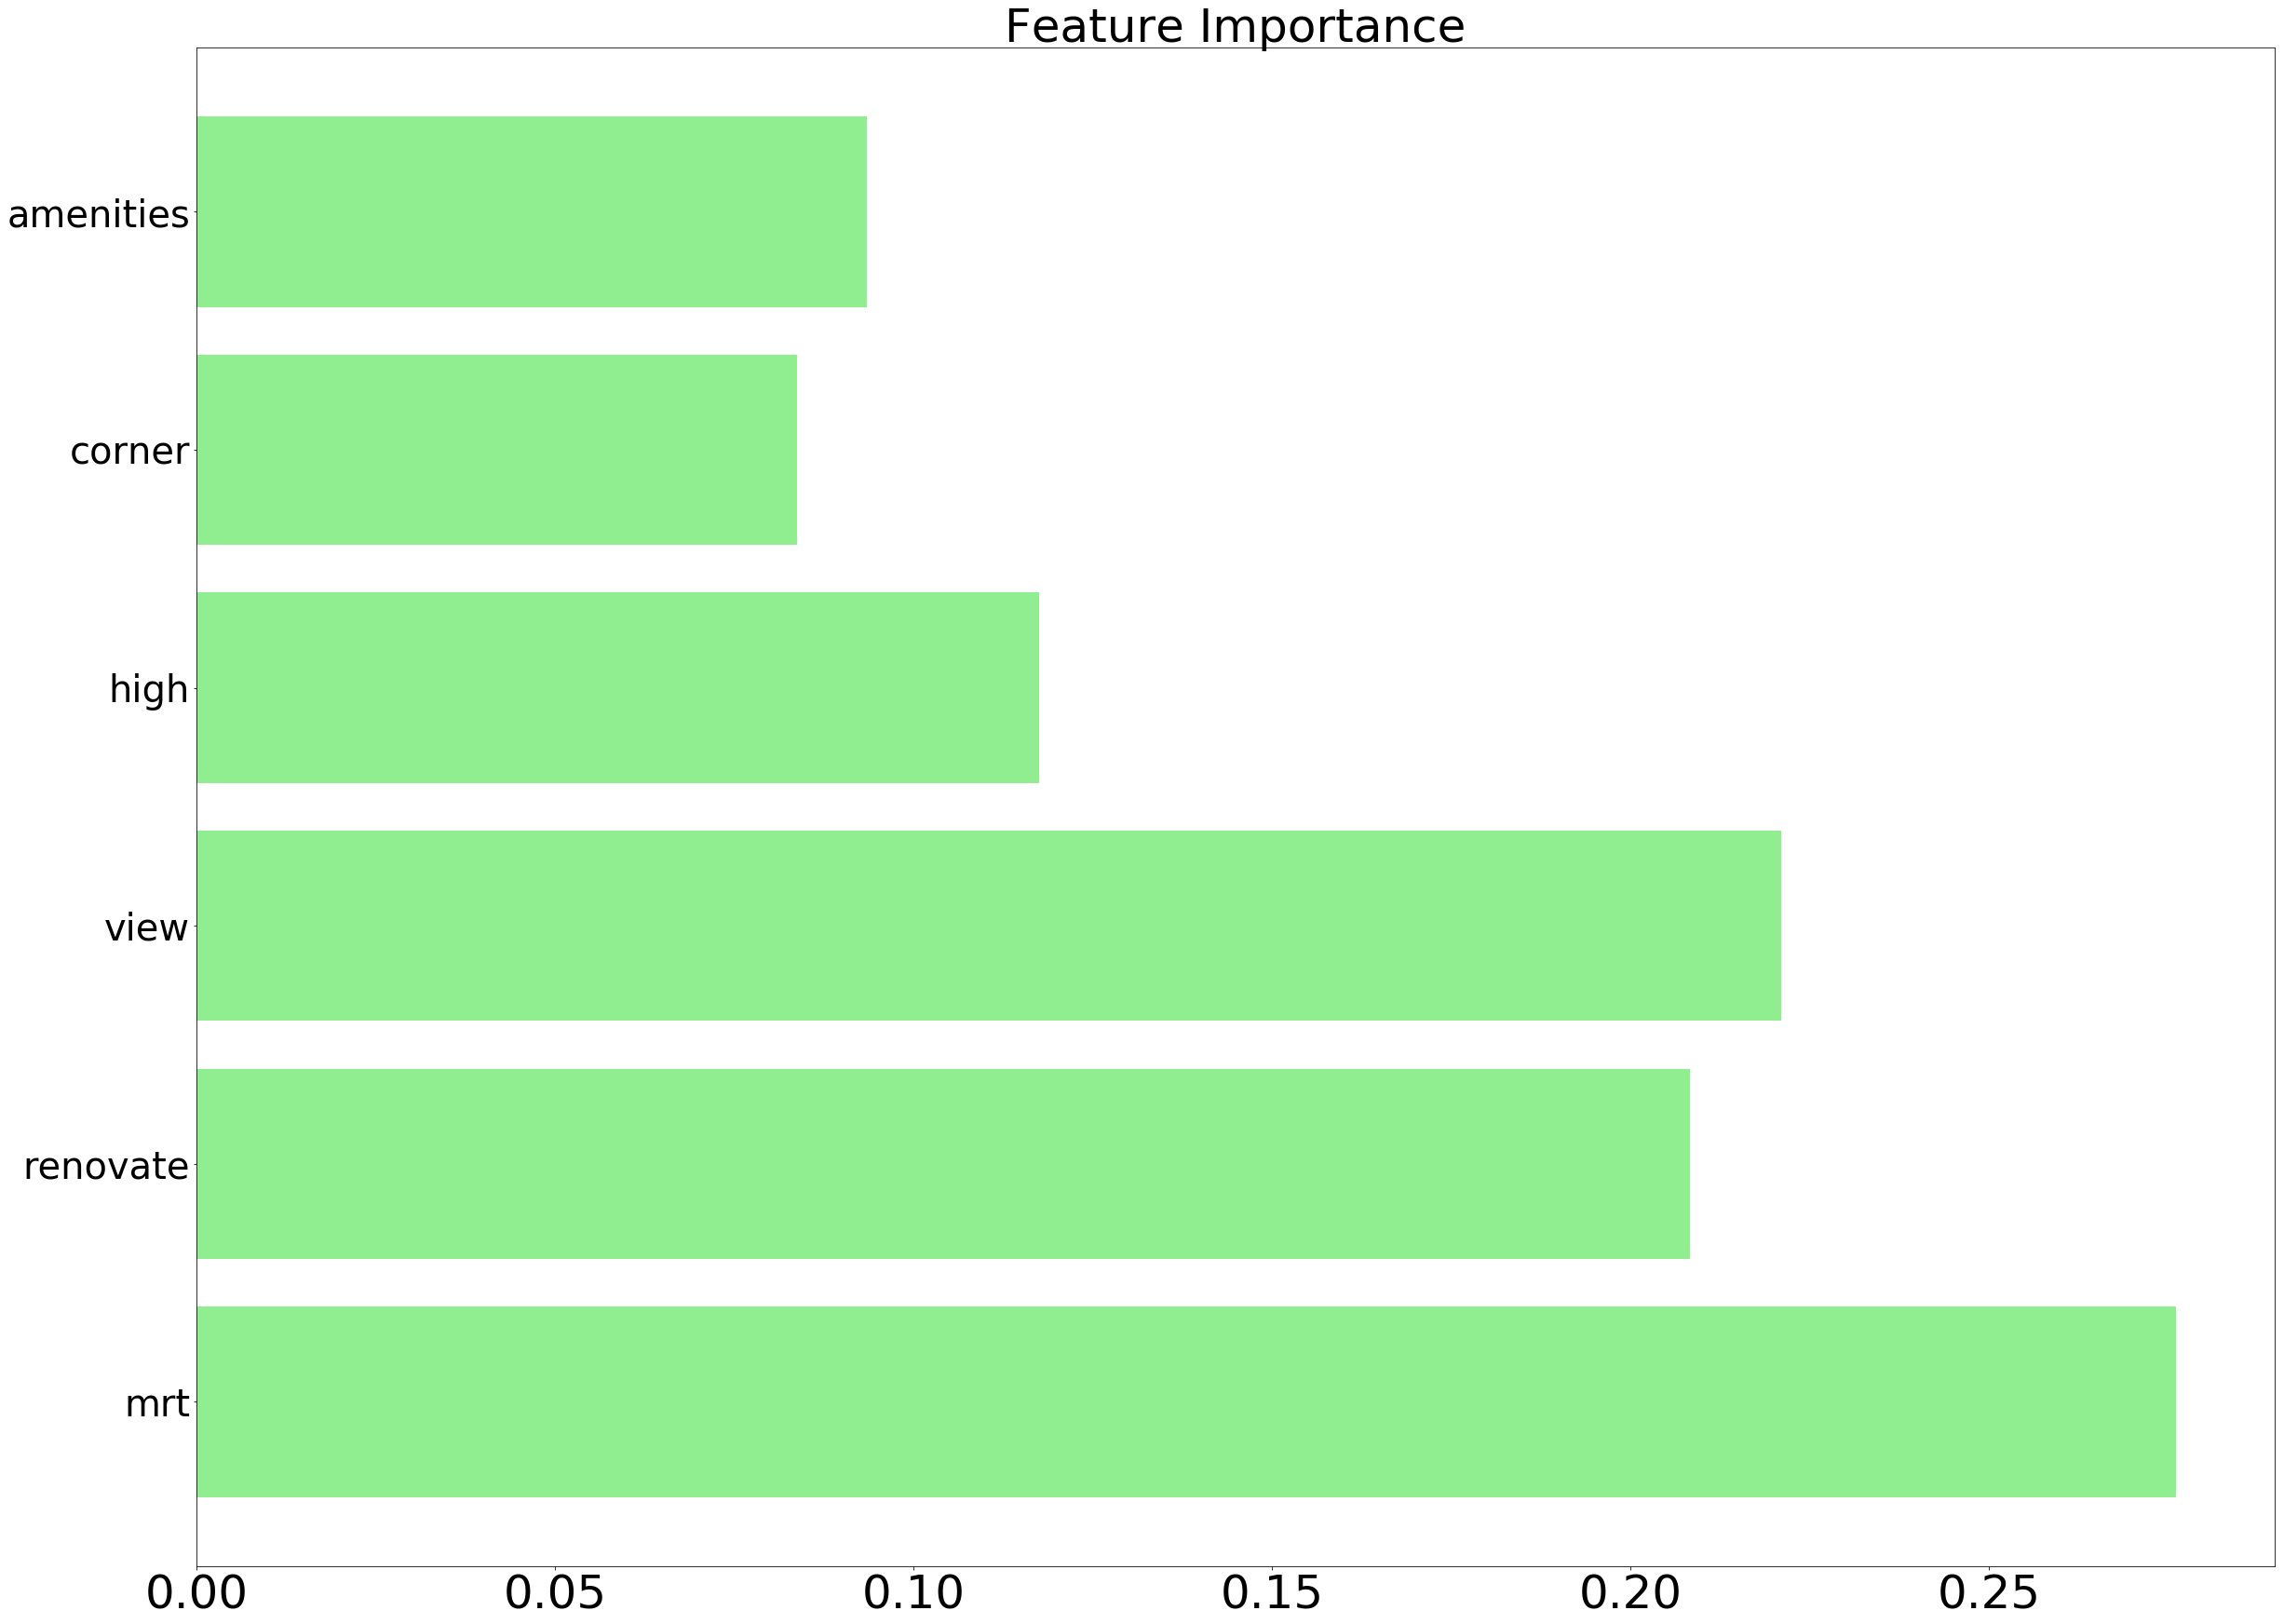

<Figure size 432x288 with 0 Axes>

In [458]:
fig = plt.figure(figsize = (40, 30))
plt.barh(features, dt_model.feature_importances_, color='lightgreen')
plt.title('Feature Importance', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(fontsize=50)
plt.show()
plt.savefig('bar_featureimportancedt.png')

This shows that the most important features are proximity to MRT and whether a flat is renovated.

## Additional Part - Checking my web-scraped data against established sources  

Since my model seems to have limited effectiveness, I use existing dataset which I downloaded from data.gov.sg, and want to identify if the downloaded dataset has any variable that is similar to my model. Then, I can see how predictive the model can be when I am using this larger and more established dataset. 

The dataset is HDB Resale Prices from 2017 to 2019, and I later filtered to Ang Mo Kio town only. Since property market has ups and downs, as seen from Resale Price Index, it is not helpful to analyse data over a long time period together, as psf price may increase when the economy is doing well and all resale prices increase, not because that specific flat is at a premium. Hence, I only use data from 2017 to 2019 instead of a longer time period.

This will help me better understand if it is the feature that is not a good predictor, or if my dataset is not a good predictor, not robust. 

From the downloaded dataset, one feature I can tell is whether the flat is on high floor or not, and use to see the effect on psf price.

In [459]:
hdb_resale_df = pd.read_csv('hdb_resale_2017_2019.csv')
# hdb_resale_df.head() #check

In [460]:
#filter out for units in ang mo kio only
cond_amk = hdb_resale_df['town'] == 'ANG MO KIO'
hdb_resale_amk_df = hdb_resale_df[cond_amk]

len(hdb_resale_amk_df) #check if sufficient rows for analysis: 2588 OK
hdb_resale_amk_df.head() 


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


From the data (above), I identify features that are similiar to the data scraped and used in Phase 1 of my analysis. From 'storey_range', I can determine if an entry belongs to a 'high' floor or not, which is one of the categories in the earlier dataset. 

In [461]:
#only keep necessary columns
hdb_resale_amk_filtered_df = hdb_resale_amk_df[['storey_range', 'floor_area_sqm', 'resale_price' ]]

#obtain necessary columns psf 
hdb_resale_amk_filtered_df['sqft'] = hdb_resale_amk_filtered_df['floor_area_sqm']*10.7639
hdb_resale_amk_filtered_df['psf'] = hdb_resale_amk_filtered_df['resale_price']/hdb_resale_amk_filtered_df['sqft']
hdb_resale_amk_filtered_df.head()

#convert to whether high floor or not,since typical blocks have 12 storeys, high floor means 10 to 12 floor, and for point blocks with more than 12 floors, any unit 10 to 12 oir hgiher can also be considered high

hdb_resale_amk_filtered_high_list = []

for row in hdb_resale_amk_filtered_df['storey_range']:
    if row == '01 TO 03':
        hdb_resale_amk_filtered_high_list.append(0)
    elif row == '04 TO 06':
        hdb_resale_amk_filtered_high_list.append(0)
    elif row == '07 TO 09':
        hdb_resale_amk_filtered_high_list.append(0)
    else:
        hdb_resale_amk_filtered_high_list.append(1)
        
hdb_resale_amk_filtered_df['high'] = hdb_resale_amk_filtered_high_list
hdb_resale_amk_filtered_df.head() #check

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

,storey_range,floor_area_sqm,resale_price,sqft,psf,high
0,10 TO 12,44.0,232000.0,473.6116,489.852867,1
1,01 TO 03,67.0,250000.0,721.1813,346.653470,0
2,01 TO 03,67.0,262000.0,721.1813,363.292836,0
3,04 TO 06,68.0,265000.0,731.9452,362.048962,0
4,01 TO 03,67.0,265000.0,721.1813,367.452678,0


In [462]:
print(hdb_resale_amk_filtered_df['psf'].describe())

resale_psf_mean = hdb_resale_amk_filtered_df['psf'].mean()
resale_psf_half = []
for row in hdb_resale_amk_filtered_df['psf']:
    if row <= resale_psf_mean:
        resale_psf_half.append(0)
    
    else:
        resale_psf_half.append(1)
        
hdb_resale_amk_filtered_df['psf_half'] = resale_psf_half


count    2588.000000
mean      441.755825
std       101.655989
min       274.177530
25%       375.711187
50%       409.051094
75%       465.451386
max       786.295339
Name: psf, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [463]:
#use logistic regression model to see if high floor is a good predictor
#train test split

resale_x_df = hdb_resale_amk_filtered_df[['high']]
resale_y_df = hdb_resale_amk_filtered_df[['psf_half']]

x_train_resale, x_test_resale, y_train_resale, y_test_resale = train_test_split(resale_x_df, resale_y_df, test_size = 0.15, random_state=0)

In [464]:
from sklearn.linear_model import LogisticRegression
logreg_resale_model = LogisticRegression()

logreg_resale_model.fit(x_train_resale, y_train_resale)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [468]:
#predict values
predict_logreg = logreg_resale_model.predict(x_test_resale)
print(predict_logreg) 

[1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0
 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1
 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0
 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1
 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0]


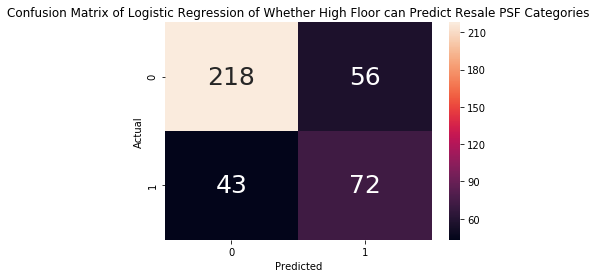

In [466]:
#create confusion matrix
resale_cm = confusion_matrix(y_test_resale, predict_logreg)

fig = sns.heatmap(resale_cm,
           annot=True,
            fmt ="d",
           annot_kws = {'size':25})
fig.set_title('Confusion Matrix of Logistic Regression of Whether High Floor can Predict Resale PSF Categories')
fig.set(xlabel='Predicted', ylabel='Actual')

plt.show()

###### Assess model's accuracy and precision

In [467]:
RSAccuracy = (72+218)/(218+56+43+72)
print("Accuracy is:", RSAccuracy)
RSPrecision = 72/(56+72)
print("Precision is:", RSPrecision)

Accuracy is: 0.7455012853470437
Precision is: 0.5625


Accuracy is at 0.74 which suggests that 74% of its predictions are accurate. This is quite high, and suggests that whether a floor is high can affect the psf pricing of a flat.

Precision is at 0.56 which suggests that when predicted a unit to have price above mean (positive), 56% it is true while 44% the unit is having a price below mean.

## Conclusion

### Summary of Project and Findings
#### Part 1: Identifying commonly promoted features 
First, I  web-scraped property listings of HDB flats on 99.co to obtain the text comments (blurbs) of the property listings put up by the seller/agent. Then, I did text normalisation and through exploratory data analysis techniques and some visualisations(bar graph, word cloud), I could pick out the words most commonly used in listings. 
Then, by grouping these words into categories, I found that the **most commonly promoted features** of a flat are: 
<br> a) Proximity to MRT 
<br> b) Whether a flat is renovated
<br> c) Whether a flat has a nice unblocked view
<br> d) Whehter a flat is on a high floor
<br> e) Whether a flat is a corner unit
<br> f) Whether a flat is close to amenities like shops, supermarkets, coffeeshops

#### Part 2: Machine-Learning 
I labelled each comment, using multi-label text classification as one comment could be promoting multiple features - e.g. a seller could write that the flat is on a high floor and close to the MRT. Then, I used this to train the Naives Bayer Multinomial Classifier. 

This is for future use - so that in future, we can feed in text comments from property listings, and the model can predict the labels (e.g. whether a flat is advertised to be near to MRT etc). Then, the next machine learning models to predict price premium can be used.

However, after assessing the model score, it was 51%. I will touch on shortcomings of data later.

#### Part 3: Machine Learning - Linear Regression and Decision Tree Classifier
Secondly, Then, I encoded the variables (binary) and trained a linear regression model to see the effect on psf price. 
I found that the feature that has the greatest effect on psf pricing is **whether a flat is renovated** (largest coefficient). However, the model had a low r2 value (0.04). I will touch on shortcomings of data later.

Even after trying feature selection to drop one feature, the r2 score did not change significantly. 

Hence, I converted the continuous psf price variable into categorical variable. Instead of predicting the psf price as the independent variables may not be sufficient to predict it accurately, I predict whether the psf price is above mean (coded as 1) or below mean (coded as 0). Since the dependent variable is categorical, I used decision tree classifier. 

When using decision tree classifier, the feature that has the greatest effect on psf pricing is **whether a flat is near to the MRT**. The decision tree classifier had accuracy of 59% and precision of 33%. Although precision is low, accuracy of 59% suggests that the model has some predictive power, although of course it could be improved on. 

#### Part 4: Comparing one feature to downloaded dataset
I wanted to know if the features themselves had significant effect on psf. 
Hence, I downloaded a dataset showing HDB Resale Prices. Filtering for Ang Mo Kio town, there were 2588 entries. I tried to see if high floor (one feature in my earlier model) can affect psf price. I transformed the data to get two categorical variables, for logistic regression. The independent variable: whether the flat was on high floor (coded as 1) or not (coded as 0), dependent variable was whether psf price is above (coded 1) or below mean (coded 0). This model had accuracy of 74%.

This suggests that low predictive power of my models earlier may be more likely due to shortcomings of data.


### Shortcomings of Data and Future Findings 
There are some shortcomings of data. Firstly, due to time constraints, I scoped the project to only Ang Mo Kio. If there were more towns, perhaps, the model could be better trained given more data.

Furthermore, there are some assumptions here which may not be true.
1) The text comments are from property listings and written by sellers. They may not be accurate. Sellers may not know what features buyers value, and may not be writing about these features. For example, a flat may have nice unblocked view, which causes a buyer to want to pay more for it. Thus, the labelling of the data may not be accurate. 
2) Also, sellers may not be writing accurate comments. Such features can be subjective. They may also inflate certain features to attract more buyers. For example, they may say a flat is nicely renovated but it is their subjective opinion and a buyer may not think so. 
3) The model also only considers how positive features can affect a price, but there are also negative features that could potentially push a flat's psf pricing down, but these are not considered. For example, a flat may have positive features like having nice renovations and unblocked view, but the psf pricing may be pushed down if it has a negative feature that is not considered like being next to the rubbish chute. 
4) Finally, the psf pricing scraped are only the seller's asking price, and reflect what sellers think buyers will be willing to pay for the flat. However, it may not be accurate as sellers may not know too accurately what buyers want to pay. After negotiating, the price may change.

For future work, we could scrape data of Ang Mo Kio town over a longer time period to have more data to train the model and see if it becomes more accurate. Secondly, we could also choose to scrape data for other towns, and use them to increase the amount of data to train the model. However, to avoid the effect of price differential due to different HDB town, we must consider only the 'premium' for psf, ie. compare the flat's psf price against the mean psf for that town. 

# Comments

**Score (Out of 20):** 18
    
    
**Legend:**

- (+) What I liked
- (/) Note
- (-) Suggestion for Improvement

**Grading**

- Dataset evaluation (Out of 5) - 4
    - (+) Explored many variables available |in the data set
    - (+) Variables were visualized appriopriately
    
    
- Methodology (Out of 10)- 9

    - (+) Cleaned data using drop, dropna, renamed columns, filtering
    - (+) Excellent use of groupby and deep-dive

    
- Insights / evaluation (Out of 5) - 5
    - (+) Insights drawn from analytics
    - (+) Put in thought into analyzing the data set, attempted prediction model